<a href="https://colab.research.google.com/github/juampi20/artificial-intelligence-2022/blob/master/tp2_juanpablogarcia_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico N.°2

# Simple Linear Regression

## 1. Cargamos el dataset

In [178]:
!wget https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv -O insurance.csv

--2022-11-01 18:16:57--  https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54288 (53K) [text/plain]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  53.02K  --.-KB/s    in 0.004s  

2022-11-01 18:16:57 (13.8 MB/s) - ‘insurance.csv’ saved [54288/54288]



In [179]:
import pandas as pd

# Cargamos el dataset
data = pd.read_csv("insurance.csv")

# Mostramos las primeras 5 filas
data.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [180]:
# Eliminamos las columnas no numericas
data.drop(columns=['sex', 'smoker', 'region'], inplace=True, axis=1)
data.head(5)

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


## 2. Elegimos una sola variable

En mi caso, voy a elegir solo `age` (Edad del cliente) como variable **X** y voy a intentar modelar la relación con `charges` (Costo del seguro), es decir, esta va a ser la variable **Y**.

In [181]:
x = data['age'].to_numpy() # Seleccionamos solo la columna "age" como datos de la variable independiente X
y = data['charges'].to_numpy() # Seleccionamos la columna "charges" como datos para supervisar el entrenamiento

## 3. Analizamos el dataset

Para esto analizaremos las siguientes características:

1. Normalidad de los datos.
2. Como se distribuyen.
3. Correlación

In [182]:
# Normalidad la calculamos usando el test de Shapiro-Wilk
from scipy.stats import shapiro
normalidad_x = shapiro(x)
normalidad_y = shapiro(y)

print(f"Normalidad de X: {normalidad_x}")
print(f"Normalidad de Y: {normalidad_y}")

Normalidad de X: ShapiroResult(statistic=0.9446991682052612, pvalue=5.687479624670986e-22)
Normalidad de Y: ShapiroResult(statistic=0.814687967300415, pvalue=1.150477698013898e-36)


> **Nota:** vemos que para ambos conjuntos de datos X e Y, el p-value es < 0.05 por lo cual se rechaza la hipotesis nula (H0) de que se distribuyen de forma normal. Habría que analizar que "otra forma de distribución pueden tener". Al saber que no se distribuyen de forma normal no se puede hacer un test de correlación de Pearson, pero si tal vez de Kendall...

Vemos como se distribuyen ambos conjuntos de datos X e Y

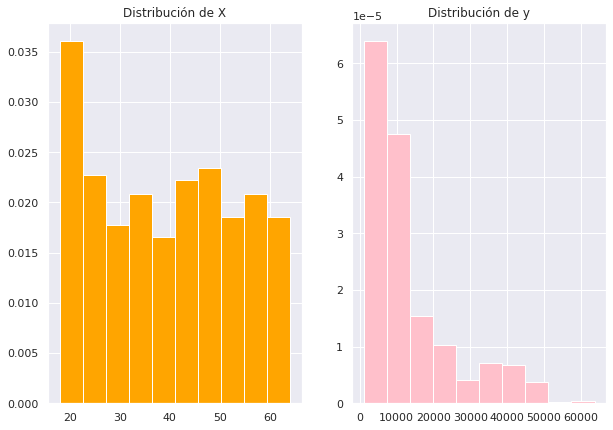

In [183]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.hist(x,color='orange',density=True)
plt.title("Distribución de X")
plt.subplot(1,2,2)
plt.hist(y,color='pink',density=True)
plt.title("Distribución de y");

Analizamos si se correlacionan a traves de una grafica de **scatter plot** o un **mapa de calor** o un **pairplot**.

Ya que no se distribuyen de forma normal, usaremos un test de correlacion de **Kendall**.

Text(0.5, 1.0, 'Mapa de calor de correlación entre ambas variables')

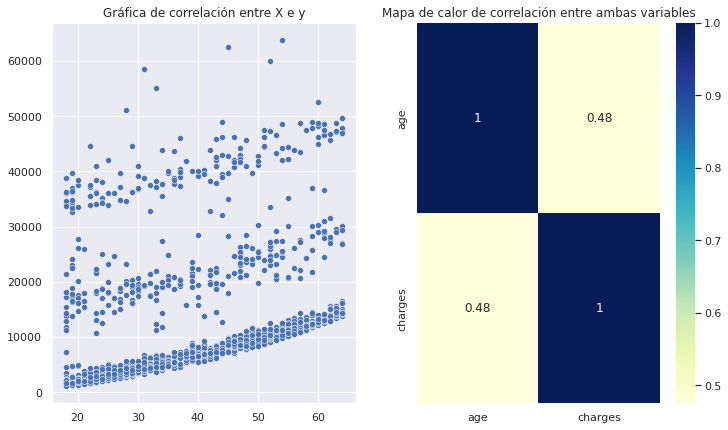

In [184]:
import seaborn as sns

sns.set()

plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
sns.scatterplot(x=x, y=y)
plt.title("Gráfica de correlación entre X e y")
plt.subplot(1,2,2)
sns.heatmap(data[["age","charges"]].corr(method='kendall'), cmap='YlGnBu', annot=True)
plt.title("Mapa de calor de correlación entre ambas variables")

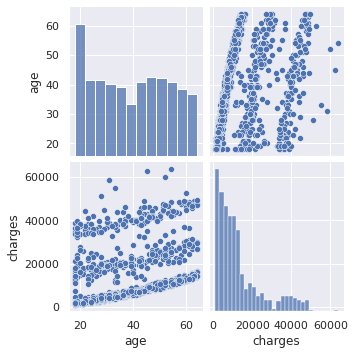

In [185]:
# Luego hacemos un pairplot
sns.pairplot(data[["age","charges"]]);

> **Nota:** Este analisis de correlacion nos muestra que graficamente tanto en `scatterplot` como en `pairplot` podemos ver que entre las dos variables llegan a logran una orientacion lineal. Por otro lado, el mapa de calor nos muestra el `valor` de la correlacion entre las variables que es de 0.48, lo que es algo moderado. Llegados a este analisis, podemos concluir que, entre estas variables, existe una correlacion moderada ya que los datos pueden llegar a representar una relacion lineal.

## 4. Separamos el dataset en entrenamiento y testeo

In [186]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=42)

In [187]:
# Vemos las especificaciones de cada conjunto de datos formados
print(f"Xtrain shape: {Xtrain.shape} | ytrain shape {ytrain.shape}")
print(f"Xtest shape: {Xtest.shape} | ytest shape {ytest.shape}")

Xtrain shape: (1003,) | ytrain shape (1003,)
Xtest shape: (335,) | ytest shape (335,)


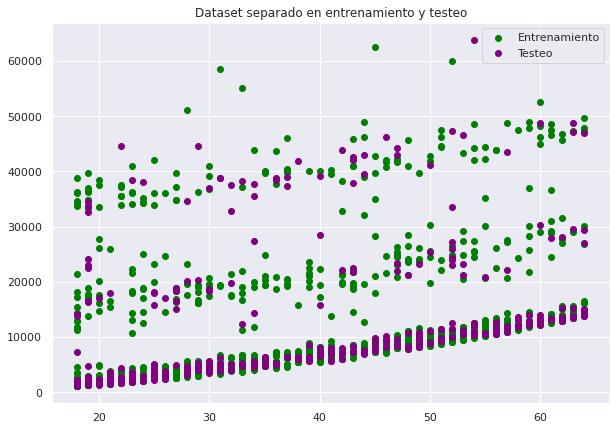

In [188]:
# Grafico de como queda el dataset separado en entrenamiento y testeo 
plt.figure(figsize=(10,7))
plt.scatter(Xtrain,ytrain,c='green',label='Entrenamiento')
plt.scatter(Xtest,ytest,c='purple',label='Testeo')
plt.legend()
plt.title("Dataset separado en entrenamiento y testeo");

## 5. Entrenamos el modelo de regresión lineal simple

In [189]:
from sklearn.linear_model import LinearRegression

# Para entrenar la regresion usamos el parámetro normalize=True
# para que normalice [0,1] los datos de X y así mejorar el cálculo interno del OLS
linear_model = LinearRegression(normalize=True)


In [190]:
# Entrenamos el modelo con la función .fit()
linear_model.fit(Xtrain.reshape(-1, 1),ytrain.reshape(-1, 1))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


LinearRegression(normalize=True)

In [191]:
# Vemos el coefficiente e intercepto que "aprendió" el modelo que mejor se ajustan a la relación lineal
print(f"Coeficiente que acompaña a la variable de entrada: {linear_model.coef_}")
print(f"Intercepto que corta al eje de ordenadas: {linear_model.intercept_}")

Coeficiente que acompaña a la variable de entrada: [[251.88759482]]
Intercepto que corta al eje de ordenadas: [3380.02926616]


Entonces el modelo final quedaría algo así:

`y = 251.88759482*X0 + 3380.02926616`

## 6. Evaluamos el modelo lineal entrenado

In [192]:
# Ahora miramos el R2 usando la función score del modelo entrenado
print(f"Valor de métrica R2 con el conjunto de entrenamiento: {linear_model.score(Xtrain.reshape(-1, 1),ytrain.reshape(-1, 1))}")
print(f"Valor de métrica R2 con el conjunto de testeo: {linear_model.score(Xtest.reshape(-1, 1),ytest.reshape(-1, 1))}")

Valor de métrica R2 con el conjunto de entrenamiento: 0.08610344496017164
Valor de métrica R2 con el conjunto de testeo: 0.09872955304263187


In [193]:
# Calculamos predicciones para el conjunto de testeo y entrenamiento con la función .predict()
y_test_pred = linear_model.predict(Xtest.reshape(-1, 1)).squeeze() 
y_train_pred = linear_model.predict(Xtrain.reshape(-1, 1)).squeeze() 
y_test_pred.shape, y_train_pred.shape

((335,), (1003,))

In [194]:
# Comparamos los valores predichos vs originales del conjunto de testeo y entrenamiento
from sklearn import metrics as ms 
test_mae = ms.mean_absolute_error(y_true = ytest, y_pred = y_test_pred) #Calculamos el mae entre ytest vs y_test_pred
train_mae = ms.mean_absolute_error(y_true = ytrain, y_pred = y_train_pred) #Calculamos el mae entre ytrain vs y_train_pred
test_mse = ms.mean_squared_error(y_true = ytest, y_pred = y_test_pred) #Calculamos el mse entre ytest vs y_test_pred
train_mse = ms.mean_squared_error(y_true = ytrain, y_pred = y_train_pred) #Calculamos el mse entre ytrain vs y_train_pred
print(f"Valor de métrica MAE con el conjunto de testeo: {test_mae}")
print(f"Valor de métrica MAE con el conjunto de entrenamiento: {train_mae}\n")
print(f"Valor de métrica MSE con el conjunto de testeo: {test_mse}")
print(f"Valor de métrica MSE con el conjunto de entrenamiento: {train_mse}")

Valor de métrica MAE con el conjunto de testeo: 9139.218471875241
Valor de métrica MAE con el conjunto de entrenamiento: 9016.357572461897

Valor de métrica MSE con el conjunto de testeo: 135993724.92343962
Valor de métrica MSE con el conjunto de entrenamiento: 132597611.08057605


In [195]:
# Como sabemos que los valores estan bien, para eso podemos ver cual es el valor promedio, maximo y minimo de conjunto de datos
print(f"Maximo: {y.max()} | Minimo: {y.min()} | Promedio: {y.mean()} | Varianza de los datos de entrada X: {x.var()}")

Maximo: 63770.42801 | Minimo: 1121.8739 | Promedio: 13270.422265141257 | Varianza de los datos de entrada X: 197.2538519888909


In [196]:
# Vemos los datos de predecidos cuanto varían con relación a los originales para darnos un sentido de la magnitud del error
error = [] # creamos una lista para guardar todos los datos obtenidos en el bucle for
for i,j in zip(ytest,y_test_pred):
  print(f"{i} vs {j:.2f} --> diferencia = {(i-j):.2f} --> error: {(int(i-j)/i)*100:.2f}%")
  error.append(abs((int(i-j)/i)*100))

9095.06825 vs 14714.97 --> diferencia = -5619.90 --> error: -61.78%
5272.1758 vs 12447.98 --> diferencia = -7175.81 --> error: -136.09%
29330.98315 vs 19500.84 --> diferencia = 9830.15 --> error: 33.51%
9301.89355 vs 14966.86 --> diferencia = -5664.97 --> error: -60.89%
33750.2918 vs 8165.89 --> diferencia = 25584.40 --> error: 75.80%
4536.259 vs 11944.21 --> diferencia = -7407.95 --> error: -163.28%
2117.33885 vs 8165.89 --> diferencia = -6048.55 --> error: -285.64%
14210.53595 vs 19500.84 --> diferencia = -5290.30 --> error: -37.23%
3732.6251 vs 10432.88 --> diferencia = -6700.26 --> error: -179.50%
10264.4421 vs 15722.52 --> diferencia = -5458.08 --> error: -53.17%
18259.216 vs 10936.66 --> diferencia = 7322.56 --> error: 40.10%
7256.7231 vs 13707.42 --> diferencia = -6450.70 --> error: -88.88%
3947.4131 vs 10684.77 --> diferencia = -6737.36 --> error: -170.67%
46151.1245 vs 14966.86 --> diferencia = 31184.27 --> error: 67.57%
48673.5588 vs 18493.28 --> diferencia = 30180.27 --> err

In [197]:
# Calculamos el error promedio
print(f"El error promedio de las predicciones con el conjunto de testeo es: {sum(error)/len(error):.2f}%")

El error promedio de las predicciones con el conjunto de testeo es: 117.63%


# Multiple Linear Regression

## 1. Cargamos el dataset

In [198]:
data = pd.read_csv('insurance.csv')
data.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 2. Eliminamos las variables no numericas

In [199]:
data.drop(columns=['sex', 'smoker', 'region'], inplace=True, axis=1)
data.head(5)

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


## 3. Elegimos las variables

In [200]:
X = data[['age', 'bmi']].to_numpy()
y = data['charges'].to_numpy()

In [201]:
# Observamos el formato, la cantidad de datos que hay en cada variable y 5 ejemplos de cada variable
print(f"X ('age','bmi') tiene la forma: {X.shape} | posee cantidad de datos: {len(X)} | 5 ejemplos se ven así: {X[:5]}\n")
print(f"Y ('charges') tiene la forma: {y.shape} | posee cantidad de datos: {len(y)} | 5 ejemplos se ven así: {y[:5]}")

X ('age','bmi') tiene la forma: (1338, 2) | posee cantidad de datos: 1338 | 5 ejemplos se ven así: [[19.    27.9  ]
 [18.    33.77 ]
 [28.    33.   ]
 [33.    22.705]
 [32.    28.88 ]]

Y ('charges') tiene la forma: (1338,) | posee cantidad de datos: 1338 | 5 ejemplos se ven así: [16884.924    1725.5523   4449.462   21984.47061  3866.8552 ]


## 4. Analizamos el dataset
**Se analiza:** Normalidad de los datos, como se distribuyen y la correlacion.

In [202]:
from scipy.stats import shapiro
# Normalidad la calculamos usando el test de Shapiro-Wilk
normalidad_X_age = shapiro(X[:,0]) # evaluamos normalidad de los datos de X ('age')
normalidad_X_bmi = shapiro(X[:,1]) # evaluamos normalidad de los datos de X ('bmi')
normalidad_y = shapiro(y) # evaluamos normalidad de los datos de y

print(f"Normalidad de X_age: {normalidad_X_age}")
print(f"Normalidad de X_bmi: {normalidad_X_bmi}")
print(f"Normalidad de y: {normalidad_y}")

Normalidad de X_age: ShapiroResult(statistic=0.9446991682052612, pvalue=5.687479624670986e-22)
Normalidad de X_bmi: ShapiroResult(statistic=0.9938876032829285, pvalue=2.609841976664029e-05)
Normalidad de y: ShapiroResult(statistic=0.814687967300415, pvalue=1.150477698013898e-36)


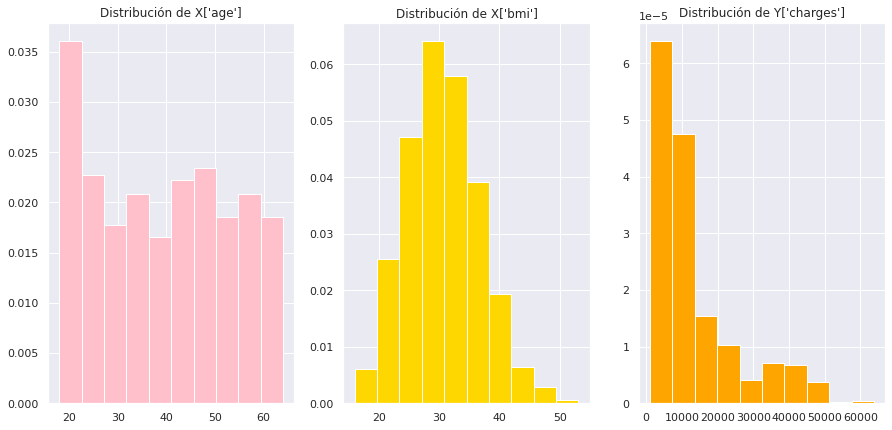

In [203]:
# Vemos como se distribuyen ambos conjuntos de datos X e Y
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.hist(X[:,0],color='pink',density=True)
plt.title("Distribución de X['age']")
plt.subplot(1,3,2)
plt.hist(X[:,1],color='gold',density=True)
plt.title("Distribución de X['bmi']")
plt.subplot(1,3,3)
plt.hist(y,color='orange',density=True)
plt.title("Distribución de Y['charges']");

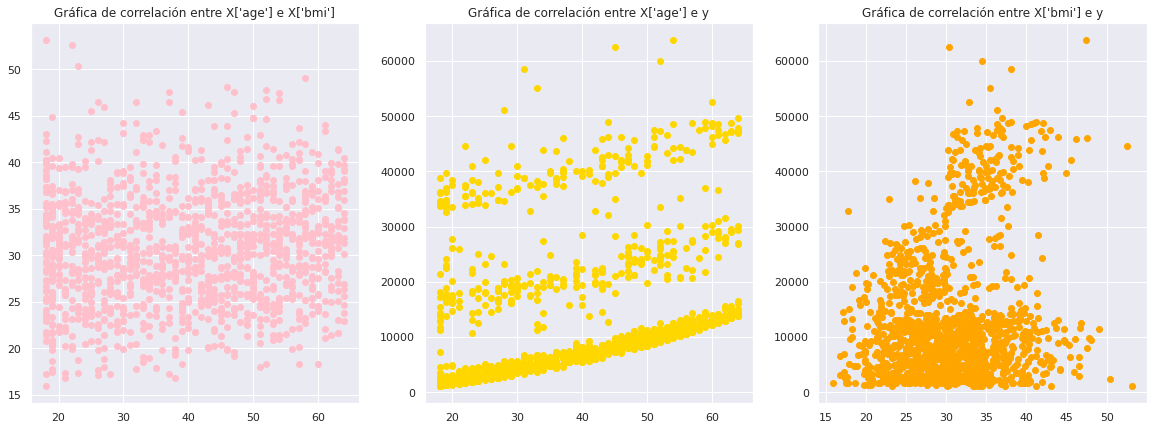

In [204]:
# Vemos si se correlacionan
# Hacemos primero un scatterplot
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.scatter(X[:,0],X[:,1],color='pink')
plt.title("Gráfica de correlación entre X['age'] e X['bmi']")
plt.subplot(1,3,2)
plt.scatter(X[:,0],y,color='gold')
plt.title("Gráfica de correlación entre X['age'] e y")
plt.subplot(1,3,3)
plt.scatter(X[:,1],y,color='orange')
plt.title("Gráfica de correlación entre X['bmi'] e y");

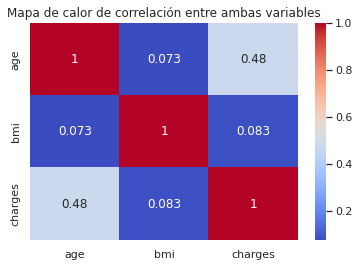

In [205]:
sns.heatmap(data.drop(columns=['children']).corr(method='kendall'), cmap='coolwarm', annot=True)
plt.title("Mapa de calor de correlación entre ambas variables");

## 5. Transformamos los datos
En orden de escalar los datos dentro de un mismo rango de valores, conservando su propia distribución, podemos hacerlo con `StandarScaler` o `MinMaxScale` , ambos de Scikit-Learn.

`MinMaxScaler(feature_range = (0, 1))` transformará cada valor de la columna proporcionalmente dentro del rango [0,1]. Utilice esto como la primera opción de escalador para transformar una característica (feature), ya que preservará la forma del conjunto de datos (sin distorsión).

`StandardScaler()` transformará cada valor de la columna para que se sitúe alrededor de la media 0 y la desviación estándar 1, es decir, cada valor se normalizará restando la media y dividiendo por la desviación estándar. Utilice `StandardScaler` si sabe que la distribución de los datos es normal.

Si hay valores atípicos, utilice `RobustScaler()`. También puede eliminar los valores atípicos y utilizar cualquiera de los dos escaladores anteriores (la elección depende de si los datos se distribuyen normalmente).

In [206]:
# En lo particular, elegí hacerlo con MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [207]:
# Escalamos los datos de entrada X con la función .fit_transform()
X_transformed = scaler.fit_transform(X)
print(f"X_transformed: {X_transformed.shape}")

X_transformed: (1338, 2)


In [208]:
# Ploteamos como se ven 5 ejemplos de datos normales vs escalados
print(f"X original: {X[:5]}\n")
print(f"X transformed: {X_transformed[:5]}")

X original: [[19.    27.9  ]
 [18.    33.77 ]
 [28.    33.   ]
 [33.    22.705]
 [32.    28.88 ]]

X transformed: [[0.02173913 0.3212268 ]
 [0.         0.47914985]
 [0.2173913  0.45843422]
 [0.32608696 0.18146355]
 [0.30434783 0.34759214]]


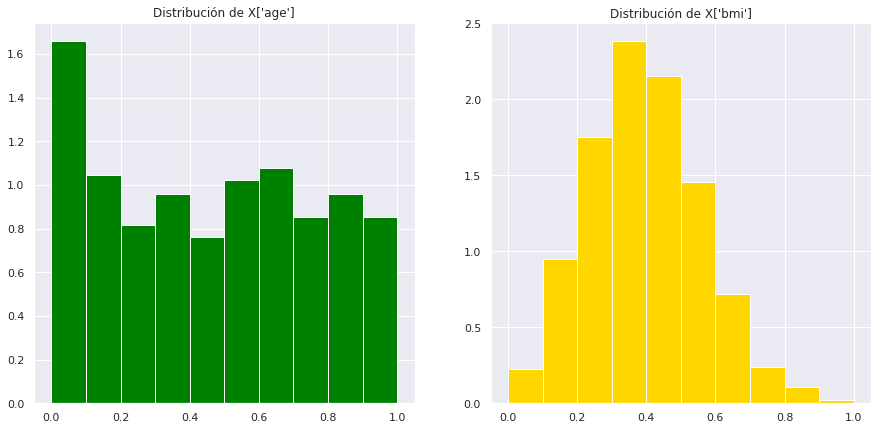

In [209]:
# Vemos como se distribuyen los valores de X_transformed
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.hist(X_transformed[:,0],color='green',density=True)
plt.title("Distribución de X['age']")
plt.subplot(1,2,2)
plt.hist(X_transformed[:,1],color='gold',density=True)
plt.title("Distribución de X['bmi']");

## 6. Separamos el dataset transformado en entrenamiento y testeo

In [210]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_transformed, y, test_size=0.25, random_state=42)
# Vemos las especificaciones de cada conjunto de datos formados 
print(f"Xtrain shape: {Xtrain.shape} | ytrain shape {ytrain.shape}")
print(f"Xtest shape: {Xtest.shape} | ytest shape {ytest.shape}")

Xtrain shape: (1003, 2) | ytrain shape (1003,)
Xtest shape: (335, 2) | ytest shape (335,)


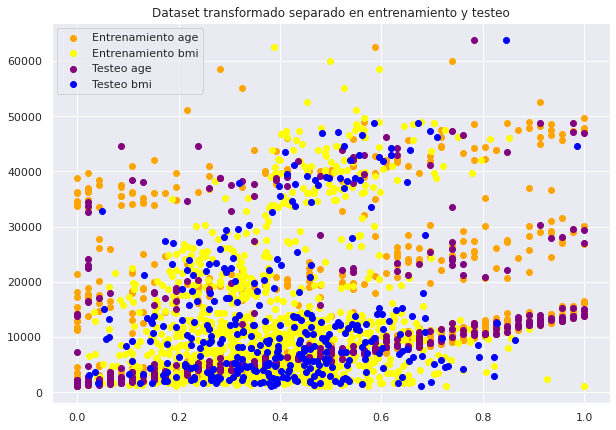

In [211]:
# Vemos gráficamente como queda el dataset transformador separado en entrenamiento y testeo
plt.figure(figsize=(10,7))
plt.scatter(Xtrain[:,0],ytrain,c='orange',label='Entrenamiento age')
plt.scatter(Xtrain[:,1],ytrain,c='yellow',label='Entrenamiento bmi')
plt.scatter(Xtest[:,0],ytest,c='purple',label='Testeo age')
plt.scatter(Xtest[:,1],ytest,c='blue',label='Testeo bmi')
plt.legend()
plt.title("Dataset transformado separado en entrenamiento y testeo");

## 7. Entrenamos el modelo de regresión

In [212]:
# Instanciamos el modelo
multilinear_model = LinearRegression()

In [213]:
multilinear_model.fit(Xtrain,ytrain)

LinearRegression()

In [214]:
# Vemos los coefficientes que "aprendió" o "encontró" el modelo que 
# mejor se ajustan a la relación multiple
print(f"Coeficiente que acompañan a las variables de entrada: {multilinear_model.coef_}")
print(f"Intercepto que corta al eje de ordenadas: {multilinear_model.intercept_}")

Coeficiente que acompañan a las variables de entrada: [10860.58595323 12307.33053626]
Intercepto que corta al eje de ordenadas: 3431.352752725019


Entonces el modelo final quedaría algo así: 

`y = 10860.58595323*X0 12307.33053626*X1 + 3431.352752725019`

## 8. Evaluamos el modelo lineal

In [215]:
# Ahora miramos el R2 usando la función score del modelo entrenado
print(f"Valor de métrica R2 con el conjunto de entrenamiento: {multilinear_model.score(Xtrain,ytrain)}")
print(f"Valor de métrica R2 con el conjunto de testeo: {multilinear_model.score(Xtest,ytest)}")

Valor de métrica R2 con el conjunto de entrenamiento: 0.11305926620508677
Valor de métrica R2 con el conjunto de testeo: 0.1288347843390777


In [216]:
# Calculamos predicciones para el conjunto de testeo y entrenamiento con la función .predict()
y_test_m_pred = multilinear_model.predict(Xtest)
y_train_m_pred = multilinear_model.predict(Xtrain) 
y_test_m_pred.shape, y_train_m_pred.shape

((335,), (1003,))

In [217]:
# Comparamos los valores predichos vs originales del conjunto de testeo y entrenamiento
from sklearn import metrics as ms 
test_mae = ms.mean_absolute_error(y_true = ytest, y_pred = y_test_m_pred) #Calculamos el mae entre ytest vs y_test_pred
train_mae = ms.mean_absolute_error(y_true = ytrain, y_pred = y_train_m_pred) #Calculamos el mae entre ytrain vs y_train_pred
test_mse = ms.mean_squared_error(y_true = ytest, y_pred = y_test_m_pred) #Calculamos el mse entre ytest vs y_test_pred
train_mse = ms.mean_squared_error(y_true = ytrain, y_pred = y_train_m_pred) #Calculamos el mse entre ytrain vs y_train_pred
print(f"Valor de métrica MAE con el conjunto de testeo: {test_mae}")
print(f"Valor de métrica MAE con el conjunto de entrenamiento: {train_mae}\n")
print(f"Valor de métrica MSE con el conjunto de testeo: {test_mse}")
print(f"Valor de métrica MSE con el conjunto de entrenamiento: {train_mse}")

Valor de métrica MAE con el conjunto de testeo: 9188.007558155274
Valor de métrica MAE con el conjunto de entrenamiento: 9000.325577239742

Valor de métrica MSE con el conjunto de testeo: 131451112.26204939
Valor de métrica MSE con el conjunto de entrenamiento: 128686580.36043614


In [218]:
# Como sabemos que los valores estan bien, para eso podemos ver cual es el valor promedio, maximo y minimo de conjunto de datos
print(f"Maximo: {y.max()} | Minimo: {y.min()} | Promedio: {y.mean()} | Varianza de los datos de entrada X: {X.var()}")

Maximo: 63770.42801 | Minimo: 1121.8739 | Promedio: 13270.422265141257 | Varianza de los datos de entrada X: 135.45536818225267


In [219]:
# Vemos los datos de precios predecidos cuanto varían con relación a los originales para darnos un sentido de la magnitud del error
error = [] # Creamos una lista para guardar todos los datos obtenidos en el bucle for
for i,j in zip(ytest,y_test_m_pred):  
    print(f"{i} vs {j:.2f} --> diferencia = {(i-j):.2f} --> error: {(int(i-j)/i)*100:.2f}%")
    error.append(abs((int(i-j)/i)*100))

9095.06825 vs 12857.22 --> diferencia = -3762.15 --> error: -41.36%
5272.1758 vs 12336.54 --> diferencia = -7064.37 --> error: -133.99%
29330.98315 vs 17909.31 --> diferencia = 11421.68 --> error: 38.94%
9301.89355 vs 13282.05 --> diferencia = -3980.15 --> error: -42.79%
33750.2918 vs 8951.96 --> diferencia = 24798.34 --> error: 73.47%
4536.259 vs 16129.03 --> diferencia = -11592.77 --> error: -255.54%
2117.33885 vs 5837.87 --> diferencia = -3720.53 --> error: -175.69%
14210.53595 vs 21558.13 --> diferencia = -7347.60 --> error: -51.70%
3732.6251 vs 6232.72 --> diferencia = -2500.10 --> error: -66.98%
10264.4421 vs 14965.46 --> diferencia = -4701.02 --> error: -45.80%
18259.216 vs 9059.11 --> diferencia = 9200.10 --> error: 50.39%
7256.7231 vs 13705.77 --> diferencia = -6449.05 --> error: -88.87%
3947.4131 vs 10541.47 --> diferencia = -6594.06 --> error: -167.05%
46151.1245 vs 18780.12 --> diferencia = 27371.01 --> error: 59.31%
48673.5588 vs 21612.03 --> diferencia = 27061.53 --> erro

In [220]:
print(f"El error promedio de las predicciones con el conjunto de testeo es: {sum(error)/len(error):.2f}%")

El error promedio de las predicciones con el conjunto de testeo es: 120.63%


# Support Vector Regressor

## 1. Cargamos el dataset

In [221]:
import pandas as pd

# Cargamos el dataset
data = pd.read_csv("insurance.csv")

# Mostramos las primeras 5 filas
data.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


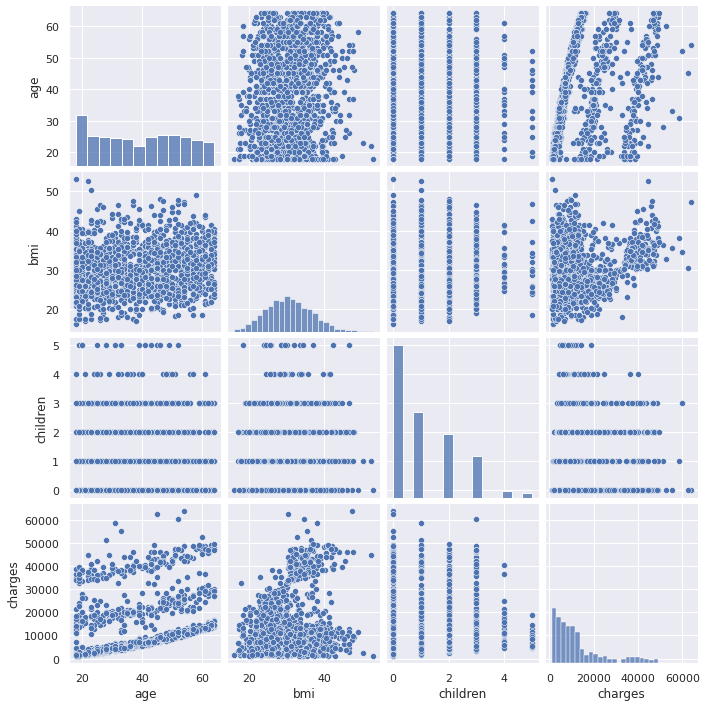

In [222]:
sns.pairplot(data.drop(columns=['sex', 'smoker', 'region']));

## 2. Evaluamos el dataset

In [223]:
from scipy.stats import shapiro

for i in data.drop(columns=['sex', 'smoker', 'region']):
  print(i, '->', shapiro(data[i]))

age -> ShapiroResult(statistic=0.9446991682052612, pvalue=5.687479624670986e-22)
bmi -> ShapiroResult(statistic=0.9938876032829285, pvalue=2.609841976664029e-05)
children -> ShapiroResult(statistic=0.8231803774833679, pvalue=5.066361280494088e-36)
charges -> ShapiroResult(statistic=0.814687967300415, pvalue=1.150477698013898e-36)


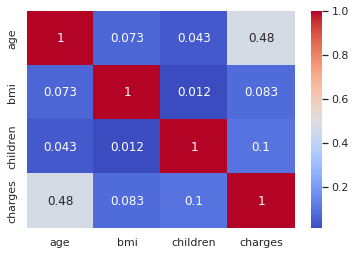

In [224]:
sns.heatmap(data.drop(columns=['sex', 'smoker', 'region']).corr(method='kendall'), cmap='coolwarm', annot=True) # Metodo de kendall

In [225]:
X = data[['charges', 'children', 'bmi']].to_numpy()
y = data['age'].to_numpy()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

In [226]:
# Importamos el modelo de support vector regressor (que usa SVM) para hacer regresiones
from sklearn.svm import SVR
svr = SVR(C=6.5,epsilon=0.5,degree=1)
svr.fit(Xtrain,ytrain)

SVR(C=6.5, degree=1, epsilon=0.5)

In [227]:
# Vemos los mejores parámetros de SVM
svr.get_params()

{'C': 6.5,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 1,
 'epsilon': 0.5,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## 3. Evaluamos SVM

In [228]:
# Ahora miramos el R2 usando la función score del modelo entrenado
print(f"Valor de métrica R2 con el conjunto de entrenamiento: {svr.score(Xtrain,ytrain)}")
print(f"Valor de métrica R2 con el conjunto de testeo: {svr.score(Xtest,ytest)}")

Valor de métrica R2 con el conjunto de entrenamiento: 0.4903809577893522
Valor de métrica R2 con el conjunto de testeo: 0.5032498199643038


In [229]:
# Calculamos predicciones para el conjunto de testeo y entrenamiento con la función .predict()
y_test_svr_pred = svr.predict(Xtest)
y_train_svr_pred = svr.predict(Xtrain) 
y_test_svr_pred.shape, y_train_svr_pred.shape

((335,), (1003,))

In [230]:
# Comparamos los valores predichos vs originales del conjunto de testeo y entrenamiento
from sklearn import metrics as ms 
test_mae = ms.mean_absolute_error(y_true = ytest, y_pred = y_test_svr_pred) #Calculamos el mae entre ytest vs y_test_pred
train_mae = ms.mean_absolute_error(y_true = ytrain, y_pred = y_train_svr_pred) #Calculamos el mae entre ytrain vs y_train_pred
test_mse = ms.mean_squared_error(y_true = ytest, y_pred = y_test_svr_pred) #Calculamos el mse entre ytest vs y_test_pred
train_mse = ms.mean_squared_error(y_true = ytrain, y_pred = y_train_svr_pred) #Calculamos el mse entre ytrain vs y_train_pred
print(f"Valor de métrica MAE con el conjunto de testeo: {test_mae}")
print(f"Valor de métrica MAE con el conjunto de entrenamiento: {train_mae}\n")
print(f"Valor de métrica MSE con el conjunto de testeo: {test_mse}")
print(f"Valor de métrica MSE con el conjunto de entrenamiento: {train_mse}")

Valor de métrica MAE con el conjunto de testeo: 5.655089265174242
Valor de métrica MAE con el conjunto de entrenamiento: 5.955793480643334

Valor de métrica MSE con el conjunto de testeo: 98.4984187414841
Valor de métrica MSE con el conjunto de entrenamiento: 100.34396909761773


In [231]:
# Vemos los datos de precios predecidos cuanto varían con relación a los originales para darnos un sentido de la magnitud del error
error = [] #creamos una lista para guardar todos los datos obtenidos en el bucle for
for i,j in zip(ytest,y_test_svr_pred):
  print(f"{i} vs {j:.2f} --> diferencia = {(i-j):.2f} --> error: {(int(i-j)/i)*100:.2f}%")
  error.append(abs((int(i-j)/i)*100))

45 vs 48.78 --> diferencia = -3.78 --> error: -6.67%
36 vs 34.32 --> diferencia = 1.68 --> error: 2.78%
64 vs 29.35 --> diferencia = 34.65 --> error: 53.12%
46 vs 49.40 --> diferencia = -3.40 --> error: -6.52%
19 vs 28.74 --> diferencia = -9.74 --> error: -47.37%
34 vs 31.16 --> diferencia = 2.84 --> error: 5.88%
19 vs 21.02 --> diferencia = -2.02 --> error: -10.53%
64 vs 56.51 --> diferencia = 7.49 --> error: 10.94%
28 vs 27.71 --> diferencia = 0.29 --> error: 0.00%
49 vs 51.95 --> diferencia = -2.95 --> error: -4.08%
30 vs 51.97 --> diferencia = -21.97 --> error: -70.00%
41 vs 42.43 --> diferencia = -1.43 --> error: -2.44%
29 vs 28.63 --> diferencia = 0.37 --> error: 0.00%
46 vs 53.77 --> diferencia = -7.77 --> error: -15.22%
60 vs 57.82 --> diferencia = 2.18 --> error: 3.33%
47 vs 49.47 --> diferencia = -2.47 --> error: -4.26%
49 vs 50.79 --> diferencia = -1.79 --> error: -2.04%
47 vs 46.43 --> diferencia = 0.57 --> error: 0.00%
46 vs 45.98 --> diferencia = 0.02 --> error: 0.00%
43 

In [232]:
print(f"El error promedio de las predicciones con el conjunto de testeo es: {sum(error)/len(error):.2f}%")

El error promedio de las predicciones con el conjunto de testeo es: 16.75%
